##### Load ENV and LLM

In [36]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
model = ChatGroq(model="llama-3.1-8b-instant")

#### Define the State

In [38]:
from pydantic import BaseModel,Field
from typing_extensions import Literal,TypedDict
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage


###Schema for structured output use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The Next Step in Routing Process")
    

## state
class State(TypedDict):
    input:str
    decision:str
    output:str
    

def llm_call01(state:State):
    """Write a Story"""
    print("LLM Call 01(Story) is Called")
    result = model.invoke(state["input"])
    return {"output":result.content}

def llm_call02(state:State):
    """Write a Poem"""
    print("LLM Call 02(Poem) is Called")
    result = model.invoke(state["input"])
    return {"output":result.content}

def llm_call03(state:State):
    """Write a joke"""
    print("LLM Call 03(Joke) is Called")
    result = model.invoke(state["input"])
    return {"output":result.content}

###Define the LLM router to routhe the input based on the input

#### Augment the LLM with Schema for Structured output
router = model.with_structured_output(Route)

def llm_call_router(state:State):
    """Route the input to the appropriate Node"""
    decision = router.invoke(
        [
            SystemMessage(content="Route the input to story,poem,and joke based on user request"),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}


#### using Condtion Function
## Conditional edge function to route to the appropriate node

def route_decision(state:State):  ###-> It works like add_conditional edges
    ##Return the Node you want to visit next
    
    if state["decision"] == "story":
        return "llm_call01"
    elif state["decision"] == "joke":
        return "llm_call02"
    elif state["decision"] == "poem":
        return "llm_call03"

#### Build the workflow

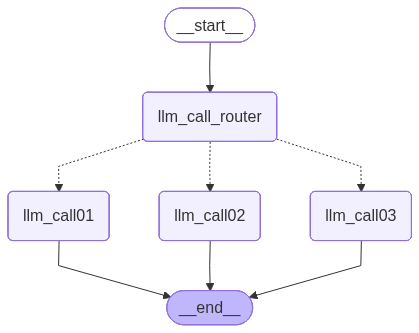

In [40]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

##Define the Graph

graph = StateGraph(State)

graph.add_node("llm_call01",llm_call01)
graph.add_node("llm_call02",llm_call02)
graph.add_node("llm_call03",llm_call03)
graph.add_node("llm_call_router",llm_call_router)

## Add Edges
graph.add_edge(START,"llm_call_router")
graph.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call01":"llm_call01",
        "llm_call02":"llm_call02",
        "llm_call03":"llm_call03"
    }
)
graph.add_edge("llm_call01",END)
graph.add_edge("llm_call02",END)
graph.add_edge("llm_call03",END)

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [41]:
result = graph_builder.invoke({
    "input":"what is ai onn joke"
})
result

LLM Call 01(Story) is Called


{'input': 'what is ai onn joke',
 'decision': 'story',
 'output': 'There are many AI-generated jokes, but here are a few examples:\n\n1. **Why did the AI go to therapy?**\nBecause it was struggling to process its emotions.\n2. **Why did the AI go on a diet?**\nBecause it wanted to lose some bytes.\n3. **Why did the AI go to the party?**\nBecause it heard it was a "byte" of fun.\n4. **What did the AI say when it ran into an old friend?**\n"I\'ve been trained on you before."\n5. **Why did the AI become a baker?**\nBecause it kneaded the dough.\n6. **Why did the AI\'s cat join a band?**\nBecause it wanted to be the purr-cussionist.\n7. **What do you call an AI that makes you laugh?**\nA byte-ful comedian.\n8. **Why did the AI go to the doctor?**\nBecause it had a virus. (get it?)\n9. **Why did the AI become a detective?**\nBecause it was good at piecing together clues.\n10. **What did the AI say when it was asked to tell a joke?**\n"I\'m still in training, but I\'m byte-ing to try."\n\nKe